# Generic MANET Simulator (Step #1)

This notebook builds a modular MANET simulator for baseline routing. It is structured to be extended later with supernodes, MAC schemes (TDMA/OFDM/NOMA), energy models, and learning-based components.

In [1]:
import math
import random
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

## Core models

In [2]:
@dataclass
class Node:
    nid: int
    x: float
    y: float
    energy: float = 1.0
    metadata: Dict = field(default_factory=dict)

@dataclass
class Flow:
    src: int
    dst: int
    demand_bps: float = 1.0

class Network:
    def __init__(self, n_nodes: int, area_w: float, area_h: float, comm_range: float, seed: Optional[int] = None):
        self.n_nodes = n_nodes
        self.area_w = area_w
        self.area_h = area_h
        self.comm_range = comm_range
        self.rng = random.Random(seed)
        self.nodes: Dict[int, Node] = {}
        self.G = nx.Graph()
        self.time = 0.0
        self._init_nodes()
        self._rebuild_graph()

    def _init_nodes(self):
        for i in range(self.n_nodes):
            x = self.rng.uniform(0, self.area_w)
            y = self.rng.uniform(0, self.area_h)
            node = Node(nid=i, x=x, y=y)
            self.nodes[i] = node

    def _distance(self, a: int, b: int) -> float:
        na, nb = self.nodes[a], self.nodes[b]
        return math.hypot(na.x - nb.x, na.y - nb.y)

    def _rebuild_graph(self):
        self.G.clear()
        for nid in self.nodes:
            self.G.add_node(nid, pos=(self.nodes[nid].x, self.nodes[nid].y))
        nids = list(self.nodes.keys())
        for i in range(len(nids)):
            for j in range(i + 1, len(nids)):
                if self._distance(nids[i], nids[j]) <= self.comm_range:
                    self.G.add_edge(nids[i], nids[j])

    def neighbors(self, nid: int) -> List[int]:
        return list(self.G.neighbors(nid))

    def move_nodes_random_waypoint(self, step_size: float = 5.0, p_teleport: float = 0.0):
        for n in self.nodes.values():
            if self.rng.random() < p_teleport:
                n.x = self.rng.uniform(0, self.area_w)
                n.y = self.rng.uniform(0, self.area_h)
            else:
                theta = self.rng.uniform(0, 2 * math.pi)
                n.x = min(max(n.x + step_size * math.cos(theta), 0), self.area_w)
                n.y = min(max(n.y + step_size * math.sin(theta), 0), self.area_h)
        self._rebuild_graph()
        self.time += 1.0

    def pos(self, nid: int) -> Tuple[float, float]:
        n = self.nodes[nid]
        return (n.x, n.y)

## Routing algorithms

In [3]:
class BaseRouter:
    name = "base"
    def route(self, net: Network, src: int, dst: int):
        raise NotImplementedError

class ShortestPathRouter(BaseRouter):
    name = "shortest_path"
    def route(self, net: Network, src: int, dst: int):
        try:
            return nx.shortest_path(net.G, source=src, target=dst)
        except nx.NetworkXNoPath:
            return None

class GreedyGeographicRouter(BaseRouter):
    name = "greedy_geo"
    def route(self, net: Network, src: int, dst: int):
        if src == dst:
            return [src]
        path = [src]
        current = src
        visited = set([src])
        max_hops = net.n_nodes
        for _ in range(max_hops):
            nbrs = net.neighbors(current)
            if not nbrs:
                return None
            curr_pos = net.pos(current)
            dst_pos = net.pos(dst)
            curr_d = math.hypot(curr_pos[0] - dst_pos[0], curr_pos[1] - dst_pos[1])

            best = None
            best_improvement = 0.0
            for nb in nbrs:
                if nb in visited:
                    continue
                nb_pos = net.pos(nb)
                d = math.hypot(nb_pos[0] - dst_pos[0], nb_pos[1] - dst_pos[1])
                improvement = curr_d - d
                if improvement > best_improvement:
                    best_improvement = improvement
                    best = nb

            if best is None:
                return None
            path.append(best)
            if best == dst:
                return path
            visited.add(best)
            current = best
        return None

## Extension hooks (for later steps)

In [4]:
class AccessModel:
    def __init__(self, mode: str = "csma_like"):
        self.mode = mode
    def describe(self):
        return f"AccessModel(mode={self.mode})"

class ClusterManager:
    def __init__(self, n_clusters: Optional[int] = None):
        self.n_clusters = n_clusters
        self.labels = {}
        self.heads = {}
    def form_clusters(self, net: Network):
        self.labels = {nid: -1 for nid in net.nodes}
        self.heads = {}

## Evaluation utilities

In [5]:
from typing import Dict, List

def evaluate_router(net: Network, router: BaseRouter, flows: List[Flow]) -> Dict:
    results = {"router": router.name, "success": 0, "attempts": len(flows), "paths": [], "hop_counts": []}
    for f in flows:
        path = router.route(net, f.src, f.dst)
        results["paths"].append(path)
        if path is not None:
            results["success"] += 1
            results["hop_counts"].append(len(path) - 1)
    if results["hop_counts"]:
        import numpy as np
        results["avg_hops"] = float(np.mean(results["hop_counts"]))
        results["median_hops"] = float(np.median(results["hop_counts"]))
    else:
        results["avg_hops"] = None
        results["median_hops"] = None
    results["pdr"] = results["success"] / max(1, results["attempts"])
    return results

def plot_network(net: Network, show_edges: bool = False, title: str = "Network"):
    import matplotlib.pyplot as plt
    plt.figure()
    xs = [net.nodes[i].x for i in net.nodes]
    ys = [net.nodes[i].y for i in net.nodes]
    plt.scatter(xs, ys, s=12)
    if show_edges:
        for u, v in net.G.edges():
            x0, y0 = net.pos(u)
            x1, y1 = net.pos(v)
            plt.plot([x0, x1], [y0, y1], linewidth=0.5)
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.show()

def plot_path_on_network(net: Network, path: List[int], title: str):
    import matplotlib.pyplot as plt
    plt.figure()
    xs = [net.nodes[i].x for i in net.nodes]
    ys = [net.nodes[i].y for i in net.nodes]
    plt.scatter(xs, ys, s=12)
    for i in range(len(path) - 1):
        x0, y0 = net.pos(path[i])
        x1, y1 = net.pos(path[i + 1])
        plt.plot([x0, x1], [y0, y1], linewidth=2)
    sx, sy = net.pos(path[0])
    dx, dy = net.pos(path[-1])
    plt.scatter([sx], [sy], s=40, marker="s")
    plt.scatter([dx], [dy], s=40, marker="^")
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.show()

def plot_hopcount_cdf(hops_a: List[int], hops_b: List[int], label_a: str, label_b: str, title: str):
    import numpy as np
    import matplotlib.pyplot as plt
    def ecdf(data):
        data_sorted = np.sort(np.array(data))
        y = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
        return data_sorted, y
    plt.figure()
    if hops_a:
        xa, ya = ecdf(hops_a)
        plt.step(xa, ya, where="post", label=label_a)
    if hops_b:
        xb, yb = ecdf(hops_b)
        plt.step(xb, yb, where="post", label=label_b)
    plt.xlabel("hop count")
    plt.ylabel("CDF")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Demo run

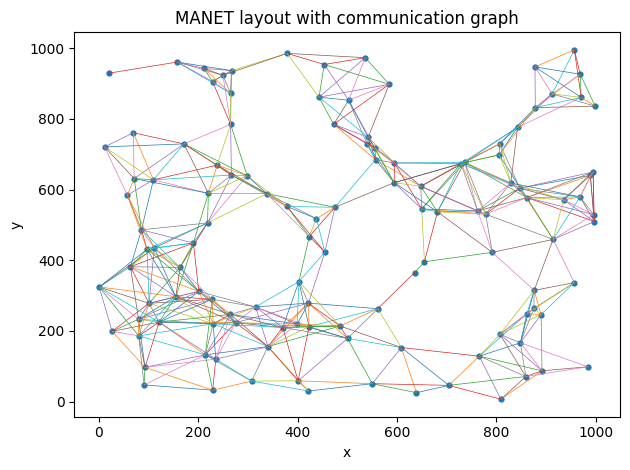

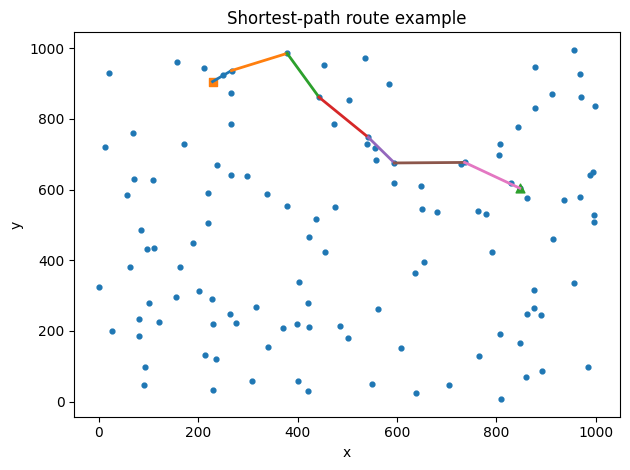

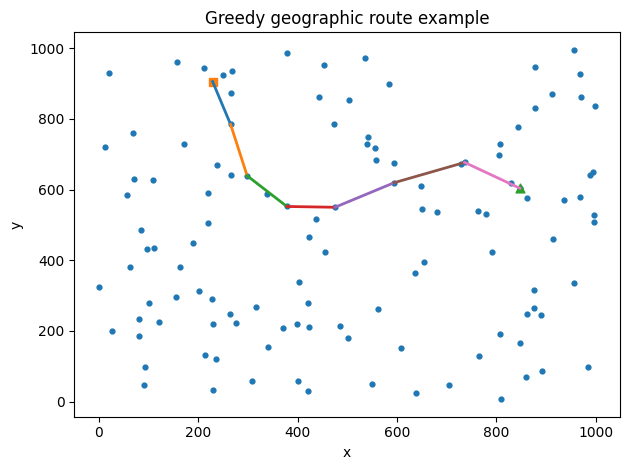

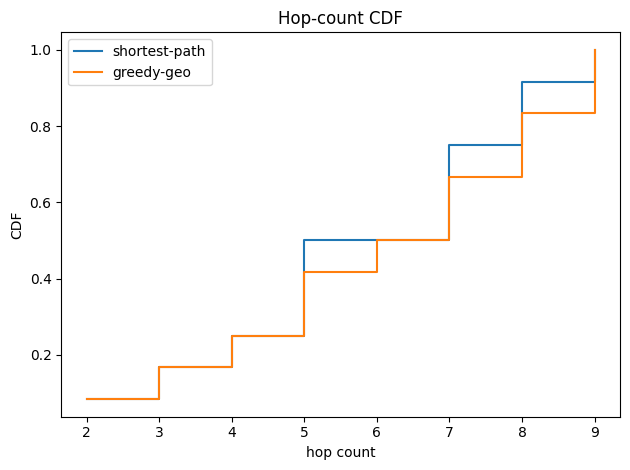

,router,attempts,success,pdr,avg_hops,median_hops
0,shortest_path,12,12,1.0,5.833333,6.0
1,greedy_geo,12,12,1.0,6.083333,6.5


In [6]:
seed = 42
net = Network(n_nodes=120, area_w=1000.0, area_h=1000.0, comm_range=160.0, seed=seed)

rng = random.Random(seed)
flows = []
pair_set = set()
while len(flows) < 12:
    s = rng.randrange(0, net.n_nodes)
    d = rng.randrange(0, net.n_nodes)
    if s != d and (s, d) not in pair_set:
        flows.append(Flow(src=s, dst=d, demand_bps=1.0))
        pair_set.add((s, d))

sp_router = ShortestPathRouter()
gg_router = GreedyGeographicRouter()

sp_results = evaluate_router(net, sp_router, flows)
gg_results = evaluate_router(net, gg_router, flows)

plot_network(net, show_edges=True, title="MANET layout with communication graph")

def first_success(results):
    for p in results["paths"]:
        if p is not None:
            return p
    return None

sp_path = first_success(sp_results)
gg_path = first_success(gg_results)
if sp_path:
    plot_path_on_network(net, sp_path, title="Shortest-path route example")
if gg_path:
    plot_path_on_network(net, gg_path, title="Greedy geographic route example")

plot_hopcount_cdf(sp_results["hop_counts"], gg_results["hop_counts"], "shortest-path", "greedy-geo", "Hop-count CDF")

import pandas as pd
summary_df = pd.DataFrame([
    {"router": sp_results["router"], "attempts": sp_results["attempts"], "success": sp_results["success"], "pdr": sp_results["pdr"], "avg_hops": sp_results["avg_hops"], "median_hops": sp_results["median_hops"]},
    {"router": gg_results["router"], "attempts": gg_results["attempts"], "success": gg_results["success"], "pdr": gg_results["pdr"], "avg_hops": gg_results["avg_hops"], "median_hops": gg_results["median_hops"]},
])
summary_df